**Name: Trilokinath Modi**

Disclaimer: The entire code is heavily influenced by the sample code provided in the course. Modifications in classes were made to perform certain tasks, but the structure of the code is largely maintained in par with the sample code.

# Using BERT

**Motivation**

CBOW model inferred that the lemma's with high training samples were generally better at accuracy. We also know from Zipf's law that most parts of the documents are made up of roughly a fifth of it's vocabulary. This implies, to capture finer details of word senses, a large training data can be benefecial. On another hand, word embeddings like BERT can be used which is essentially transfer learning. In general notion, a pre-trained neural network is used and fine tuned for purpose specific. The advantage of using BERT is it's encoding is contextualised which is exactly what word-sense needs. Intuitively, we can expect this model to perform better.

# Basic Setup

In [ ]:
!pip install transformers==3.3.1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import the PyTorch library
import torch

# a couple of utilities from the scikit-learn library
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# for time measurements
import time

# some utilities for counting
from collections import defaultdict, Counter

# plotting
import matplotlib.pyplot as plt

# plotting cosmetics
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

In [3]:
filePath = "/content/drive/My Drive/MLNLP/Assignment3/a3_data/wsd_train.txt"
filePathTest = "/content/drive/My Drive/MLNLP/Assignment3/a3_data/wsd_test_blind.txt"
filePathResult = "/content/drive/My Drive/MLNLP/Assignment3/"
fileEvaluatePy = "/content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py"
fileEvaluateTest = "/content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt"

**Functions to read and write file**

In [5]:
def readData(fileName):
    X = []
    Y = []
    posVector = []
    fileHandler = open(fileName, encoding='utf-8')
    with fileHandler:
        for line in fileHandler:
            sense, lemma, position, doc = line.strip().split(maxsplit=3)
            X.append(doc)
            Y.append(sense)
            posVector.append(position)
    return X, Y, posVector

def writeData(fileName, resultList):
  fileHandler = open(fileName, 'w')
  with fileHandler:
    for iResult in resultList:
        fileHandler.write("%s\n" % iResult)

def evaluateFile(resultFile):
  !python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt resultFile

**Using BERT Tokenizer**

In [7]:
from transformers import AutoTokenizer

In [8]:
model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Setup Classes 

In [11]:
def bert_tokenize_and_encode(tokenizer, documents, max_len):
    cls = tokenizer.cls_token_id
    sep = tokenizer.sep_token_id
    
    # Apply the BERT tokenizer and truncate the documents to the maximally allowed length.
    # (We reserve 2 positions for the dummy tokens.)
    tokenized_docs = [ tokenizer.tokenize(doc)[:max_len-2] for doc in documents ]
    
    # Encode the tokens as integers. This will automatically add the dummy tokens 
    # [CLS] at the first position and [SEP] at the last position.
    out = [ tokenizer.encode(doc) for doc in tokenized_docs ]
    
    return out

Class to handle batches

In [12]:
from torch.utils.data import Dataset, DataLoader

class DocumentDataset(Dataset):
    """A Dataset that stores a list of documents and their corresponding category labels."""
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        
    def __len__(self):
        return len(self.X)

class DocumentBatcher:
    """A collator that builds a batch from a number of documents."""
    
    def __init__(self, pad):
        self.pad = pad 
    
    def __call__(self, XY):
        """Build a batch from a number of documents. Returns two tensors X and Y, where
        X is the document tensor, of shape [n_docs, max_doc_length]

        and 
        
        Y is the label tensor, of shape [n_docs].
        """
        
        # How long is the longest document in this batch?
        max_len = max(len(x) for x, _ in XY)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad]*(max_len-len(x)) for x, _ in XY])

        # Build the label tensor.
        Y = torch.as_tensor([y for _, y in XY])

        return Xpadded, Y

Class that executes the training. The early stopping criteria is modified from CBOW and RNN early stopping criteria. For BERT, the training stops as soon as validation loss increases.

In [13]:
class TextClassifier:
    """A text classifier based on a neural network."""
    
    def __init__(self, params, tokenizer):
        self.params = params
        self.tokenizer = tokenizer
        
    def epoch(self, batches, optimizer=None):
        """Runs the neural network for one epoch, using the given batches.
        If an optimizer is provided, this is training data and we will update the model
        after each batch. Otherwise, this is assumed to be validation data.
        
        Returns the loss and accuracy over the epoch."""
        n_correct = 0
        n_instances = 0
        total_loss = 0
        
        for Xbatch, Ybatch in batches:
            
            # If we're using the GPU, move the batch there.
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)

            # Compute the predictions for this batch.
            scores = self.model(Xbatch)

            # Compute the loss for this batch.
            loss = self.loss(scores, Ybatch)

            total_loss += loss.item()
            n_instances += Ybatch.shape[0]

            # Compute the number of correct predictions, for the accuracy.
            guesses = scores.argmax(dim=1)
            n_correct += (guesses == Ybatch).sum().item()

            # If this is training data, update the model.
            if optimizer:
                optimizer.zero_grad()                
                loss.backward()
                optimizer.step()
           
        return total_loss/len(batches), n_correct/n_instances
    
    def preprocess(self, X, Y):
        """Carry out the document preprocessing, then build `DataLoader`s for the training and validation sets."""
        
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
        
        self.lbl_enc = LabelEncoder()
        self.lbl_enc.fit(Ytrain)

        self.voc_size = self.tokenizer.vocab_size
        self.n_classes = len(self.lbl_enc.classes_)
        
        batcher = DocumentBatcher(self.tokenizer.pad_token_id)
        
        train_docs = bert_tokenize_and_encode(self.tokenizer, Xtrain, self.params.max_len)
        train_dataset = DocumentDataset(train_docs, 
                                        self.lbl_enc.transform(Ytrain))
        
        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)

        val_docs = bert_tokenize_and_encode(self.tokenizer, Xval, self.params.max_len)
        val_dataset = DocumentDataset(val_docs, 
                                      self.lbl_enc.transform(Yval))
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                collate_fn=batcher)
    
    def set_model(self, model):
        """Provide a neural network model for this document classifier."""
        self.model = model
    
    def train(self):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params
        
        # If we're using a GPU, put the model there.
        self.model.to(par.device)
    
        # Declare a loss function, in this case the cross-entropy.
        self.loss = torch.nn.CrossEntropyLoss()

        # An optimizer for updating the neural network. We use the Adam optimizer.
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)
    
        # BERT recommends the AdamW optimizer, but regular Adam seems to work equally
        # well in this example.
        #optimizer = torch.optim.AdamW(self.model.parameters(), lr=par.eta, weight_decay=par.decay)
    
        # We'll log the loss and accuracy scores encountered during training.
        self.history = defaultdict(list)
        
        while epoch < par.n_epochs+1 and self.flagEpoch == 0:
            epoch += 1

            t0 = time.time()
            
            # Set the model in training mode, enabling dropout modules.
            self.model.train()
            
            # Run the model on the training data.
            train_loss, train_acc = self.epoch(self.train_loader, optimizer)
            
            # Set the model in evaluation mode, disabling dropout modules.
            self.model.eval()

            # Run the model on the validation data.            
            with torch.no_grad():
                val_loss, val_acc = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['time'].append(t1-t0)
            
            if epoch % 1 == 0:
                print(f'Epoch {epoch}: train loss:{train_loss:.4f}, train acc: {train_acc:.4f}, '
                      + f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, time: {t1-t0:.4f}')       

            if self.history['val_loss'][epoch - 1] - self.history['val_loss'][epoch - 2] > 0:
                  self.flagEpoch = 1 
        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.tokenizer.pad_token_id)
        
        # Build a DataLoader to generate the batches, as above.
        dummy_labels = [self.lbl_enc.classes_[0] for x in X]        

        enc_docs = bert_tokenize_and_encode(self.tokenizer, X, self.params.max_len)
        dataset = DocumentDataset(enc_docs, 
                                  self.lbl_enc.transform(dummy_labels))
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)
        
        # Apply the model to all the batches and aggregate the predictions.
        self.model.eval()
        output = []
        with torch.no_grad():
            for Xbatch, Ybatch in loader:
                Xbatch = Xbatch.to(self.params.device)
                Ybatch = Ybatch.to(self.params.device)
                scores = self.model(Xbatch)
                guesses = scores.argmax(dim=1)
                output.extend(self.lbl_enc.inverse_transform(guesses.cpu().numpy()))
        return output

BERT embeddings from pretrained model

In [14]:
from transformers import AutoModel
from torch import nn
import sys

class BERTEncoder(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.output_size = self.bert.config.hidden_size
    
    def forward(self, documents):
        
        # The shape of the document tensor is (n_docs, max_length), where
        # n_docs is the number of documents in the batch, and max_length is
        # the maximal document length in the batch. Since we truncate the
        # documents to length 128 in this example, max_length will be 128
        # in most cases.
        
        # Apply the BERT model to all the documents.
        bert_outputs = self.bert(documents)

        # If you want to disable fine-tuning, and keep the BERT model frozen,
        # then you would call it as follows, in order to disable gradient computation:
        # with torch.no_grad():
        #     bert_outputs = self.bert(documents)
        
        # BERT gives us four outputs (see documentation). The first element
        # of this tuple is the output of the topmost Transformer block.
        top_layer_output = bert_outputs[0]
        
        # This tensor has the shape (n_docs, max_length, output_size)
        # where output_size is the size of the contextual representation
        # for each token (768 for a standard BERT).
        
        # For a text classifier, BERT recommends that we use the representation
        # at the initial dummy token [CLS].        
        # The shape of this tensor will be (n_docs, output_size).
        cls_output = top_layer_output[:,0,:]
        
        return cls_output

The Main class to handle all operations

# Training Model

Preprocessing all documents...
... done.
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

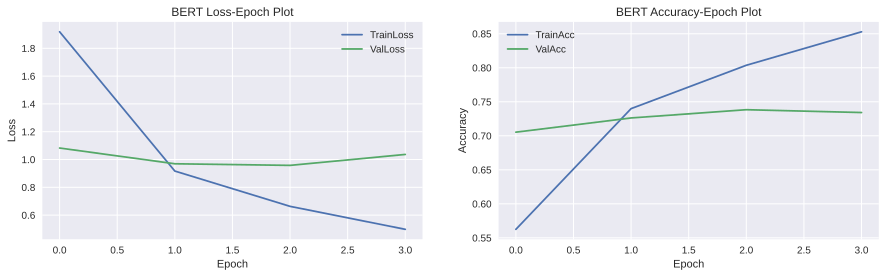

In [17]:
class TextClassifierParametersBERT:
    device = 'cuda'
        
    n_epochs = 8
    batch_size = 32
    
    eta = 5e-5 
    decay = 0
    dropout = 0.1
        
    max_len = 128
        
def main():
    global clf
    
    torch.manual_seed(0)

    X, Y, posVector = readData(filePath)
    
    bert_model_name = 'distilbert-base-uncased'
    use_bert = True
    
    if use_bert:
        params = TextClassifierParametersBERT()
    else:
        params = TextClassifierParametersCBoW()
    
    tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
    
    clf = TextClassifier(params, tokenizer)
    
    clf.preprocess(X, Y)
    
    if use_bert:
        encoder = BERTEncoder(bert_model_name)
    else:
        encoder = CBoWEncoder(tokenizer.vocab_size, params.emb_dim)
    
    # Create a classification model: a document representation with a linear classifier 
    # on top, and dropout to reduce overfitting.
    clf.set_model(nn.Sequential(
            encoder,
            nn.Dropout(params.dropout),
            nn.Linear(encoder.output_size, out_features=clf.n_classes)
    ))

    clf.train()

    plt.figure(figsize=(15, 4))
    plt.subplot(1,2,1)
    plt.plot(clf.history['train_loss'], label = "TrainLoss")
    plt.plot(clf.history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("BERT Loss-Epoch Plot")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(clf.history['train_acc'], label = "TrainAcc")
    plt.plot(clf.history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("BERT Accuracy-Epoch Plot")
    plt.legend()

    return clf

bertModel = main()


In [18]:
def plotit_bert():
    plt.figure(figsize=(15, 4))
    plt.subplot(1,2,1)
    plt.plot(bertModel.history['train_loss'], label = "TrainLoss")
    plt.plot(bertModel.history['val_loss'], label = "ValLoss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("BERT Loss-Epoch Plot")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(bertModel.history['train_acc'], label = "TrainAcc")
    plt.plot(bertModel.history['val_acc'], label = "ValAcc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"BERT Accuracy-Epoch Plot, Final Val Acc = {bertModel.history['val_acc'][len(bertModel.history['val_acc']) - 1]:.2f}, Final Train Acc = {bertModel.history['train_acc'][len(bertModel.history['train_acc']) - 1]:.2f}")
    plt.legend()

    return clf

**Testing model performance**

In [20]:
XTest, Ytest, posTest = readData(filePathTest)
for icase in range(3):
  resultList = bertModel.predict(XTest)
  fileNameRes = "BERT_result.txt"
  fileName = filePathResult + fileNameRes
  writeData(fileName, resultList)
!python3 /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/evaluate.py /content/drive/My\ Drive/MLNLP/Assignment3/a3_test/wsd_test.txt /content/drive/My\ Drive/MLNLP/Assignment3/BERT_result.txt

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Results and Inferences

The stopping criteria for BERT model was modified as compared to CBOW and RNN. With the current criteria, the training stops as soon as the validation loss increases. This may not be optimal, but is preferred due to long execution time of BERT. Hence the plots contain only 4 epochs. The plots describe the training progress and accuracy obtained for validation and training dataset. Although the epochs are slow, but the learning in each Epoch is tremendous.

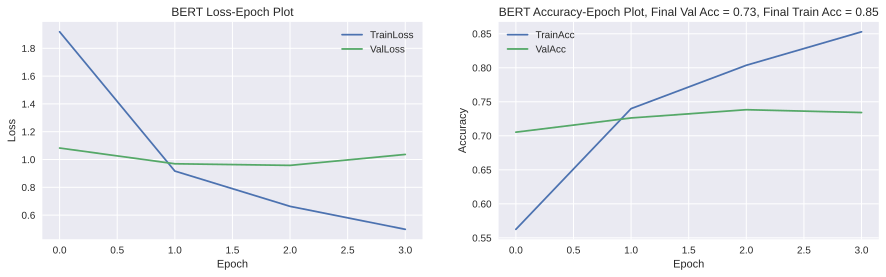

In [19]:
plotit_bert()

**Inferences from BERT**

The BERT has achieved best highest accuracy as compared to CBOW and RNN(GRU) model. The improve in validation accuracy as well as test accuracy is significant. 

Model | Train Acc | Val Acc | Test Acc
---| --- | --- | --- 
BERT | 0.85 | 0.73 | 0.74

Some top and below par predictions made on individual sense by each case are shown here:

Top | Below par
--- | ---
line.n = 0.96 | build.v = 0.50
keep.v = 0.84 | case.n = 0.51
see.v = 0.83 | bring.v = 0.55
point.n = 0.81 | lead.v = 0.60

The top and below-par lemmas in all the three cases - CBOW, RNN(GRU), BERT are quite similar. Although BERT uses pretrained model and contextualized text, it may still need a larger training data to achieve even high performances. To summarize, the BERT is extremely powerful, but the efficiency and simplicity in case of CBOW is quite commendable.


# Final Remarks

Q - What is the best way to represent a piece of text for this task? CBoW, CNN, RNN, attention?

*   The model that worked well is BERT, which primarily uses word-embeddings from pre-trained corpus. Nevertheless, if we ignore pre-trained embeddings then RNN(GRU) has worked well. Attention model may work even better, but in general to judge word sense, one may not need far past information. And hence it is expected that attention model should work closely with GRU or LSTM or may provide slight improvements.

Q - Is it useful to use some pre-trained component, such as word embeddings or pre-trained language models (ELMo, BERT etc.)?

*   Yes, it is extremely useful to use pre-trained language models like BERT. They suffice the need of extra training data in one way.

Q - How do we use the position of the target word? Should we just ignore the position and treat this as a document classification problem, or should the representation use the position somehow?

*   The position can be exploited to reduce the computational complexity. In this project, the position is used in CBOW(case - 2 and 3). A comment on global use of position is part of future work. But, intuitively, it may be exploited in specific cases prediction task. For e.g. whatsapp chat prediction for specific user "X". 

Q - Should we train completely separate classifiers for each lemma, e.g. one line.n classifier, one force.n classifier, etc.? Or just one big classifer? Or some architecture where some but not all components are shared?

*   Separate classifier for each lemma can be used to create specialized word-embeddings or in cases where high accuracies is intended for specific lemma's. In this project, all tasks were done considering one big classifier. 
